In [2]:
import io
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
import nbformat

nb = nbformat.read("Lab2_PCA-Reg.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 220


## PCA Task


 component: 1 =  [0.31492694], sum of variance: 0.3149269412240198

 component: 2 =  [0.31492694 0.17340667], sum of variance: 0.48833361383600127

 component: 4 =  [0.31492694 0.17340667 0.10378359 0.09727967], sum of variance: 0.6893968756336356

 component: 6 =  [0.31492694 0.17340667 0.10378359 0.09727967 0.06490068 0.04720747], sum of variance: 0.8015050285949457

 component: 8 =  [0.31492694 0.17340667 0.10378359 0.09727967 0.06490068 0.04720747
 0.03281148 0.03045465], sum of variance: 0.864771161523849

 component: 10 =  [0.31492694 0.17340667 0.10378359 0.09727967 0.06490068 0.04720747
 0.03281148 0.03045465 0.02272241 0.02008611], sum of variance: 0.907579683738978

 component: 13 =  [0.31492694 0.17340667 0.10378359 0.09727967 0.06490068 0.04720747
 0.03281148 0.03045465 0.02272241 0.02008611 0.0177196  0.01377721
 0.01248948], sum of variance: 0.9515659749234037

 component: 15 =  [0.31492694 0.17340667 0.10378359 0.09727967 0.06490068 0.04720747
 0.03281148 0.03045465 0.0

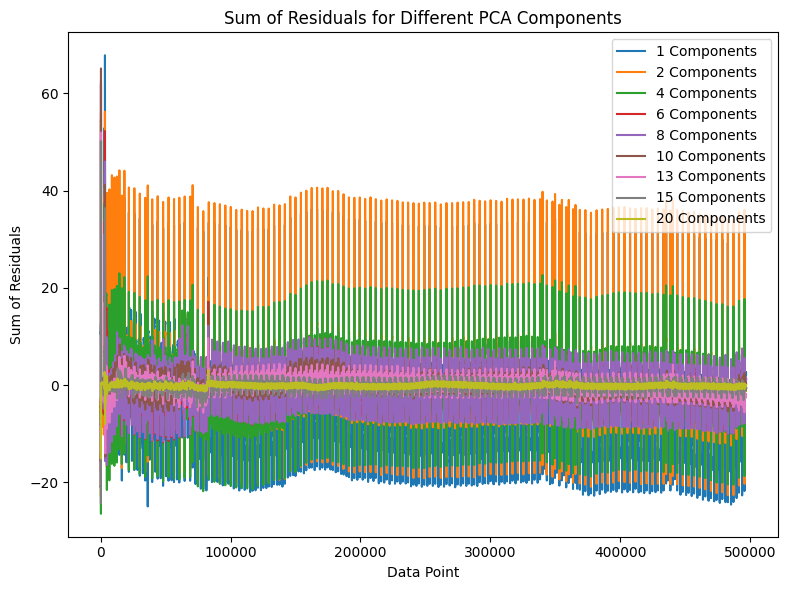

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# read the test data
df2 = pd.read_csv("train_data.csv")
df2.drop(['Id', 'Timestamp', 'Label'], axis=1, inplace=True)

scaler = StandardScaler()
df2_scaled = scaler.fit_transform(df2)

# Perform PCA with varying number of components
num_components = [1, 2, 4, 6, 8, 10, 13, 15, 20]  # Specify the desired number of components
residuals_sum_list = []

for n in num_components:
    pca = PCA(n_components=n)
    pca.fit(df2_scaled)
    df2_pca = pca.transform(df2_scaled)
    df2_reconstructed = pca.inverse_transform(df2_pca)
    residuals = df2_scaled - df2_reconstructed
    residuals_sum = residuals.sum(axis=1)  # Calculate sum of residuals for each data point
    residuals_sum_list.append(residuals_sum)
    print(f'\n component: {n} =  {pca.explained_variance_ratio_}, sum of variance: {sum(pca.explained_variance_ratio_)}')

# Plot the residuals for different number of components using snslineplot
plt.figure(figsize=(8, 6))

for i, residuals_sum in enumerate(residuals_sum_list):
    plt.plot(range(len(residuals_sum)), residuals_sum, linestyle='-', label=f'{num_components[i]} Components')

plt.xlabel('Data Point')
plt.ylabel('Sum of Residuals')
plt.title('Sum of Residuals for Different PCA Components')
plt.legend()
plt.tight_layout()
plt.show()


In [41]:
data_train = "train_data.csv"
data_val = "val_data.csv"
train_df = pd.read_csv(data_train)
val_df = pd.read_csv(data_val)
original_train = train_df.copy()
orginal_val = val_df.copy()

train_df = train_df.drop(['Id', 'Timestamp'], axis=1)
val_df = val_df.drop(['Id', 'Timestamp'], axis=1)

# apply PCA to the data for anomaly detection
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
train_df_scaled = scaler.fit_transform(train_df)
val_df_scaled = scaler.transform(val_df)

components = 15
pca = PCA(n_components=components)
pca.fit(train_df_scaled)
train_df_pca = pca.transform(train_df_scaled)
val_df_pca = pca.transform(val_df_scaled)

df_principal = pd.DataFrame(data=train_df_pca)
# print(df_principal.head())

df_principal_val = pd.DataFrame(data=val_df_pca)
# print(df_principal_val.head())

# reconstruct the data
df_reconstructed = pca.inverse_transform(train_df_pca)
df_reconstructed = pd.DataFrame(data=df_reconstructed, columns=train_df.columns)

df_reconstructed_val = pca.inverse_transform(val_df_pca)
df_reconstructed_val = pd.DataFrame(data=df_reconstructed_val, columns=val_df.columns)

# calculate the difference between the original data and the reconstructed data
residuals = train_df_scaled - df_reconstructed
# display(residuals)

residuals_val = val_df_scaled - df_reconstructed_val
# display(residuals_val)

In [83]:
# plot the sum of the residuals for components = 6 
summed_residuals = residuals.sum(axis=1)
summed_residuals_val = residuals_val.sum(axis=1)
residuals_val_label_1 = residuals_val[residuals_val['Label'] == 1]
# change values of labels from 1 to 10 for residuals_val
residuals_val_label_1['Label'] = 10

print(summed_residuals.shape)
print(summed_residuals_val.shape)

(496800,)
(224959,)


/var/folders/f5/pgcxx91x31l672vfgh983wcr0000gn/T/ipykernel_8982/1921923237.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residuals_val_label_1['Label'] = 10


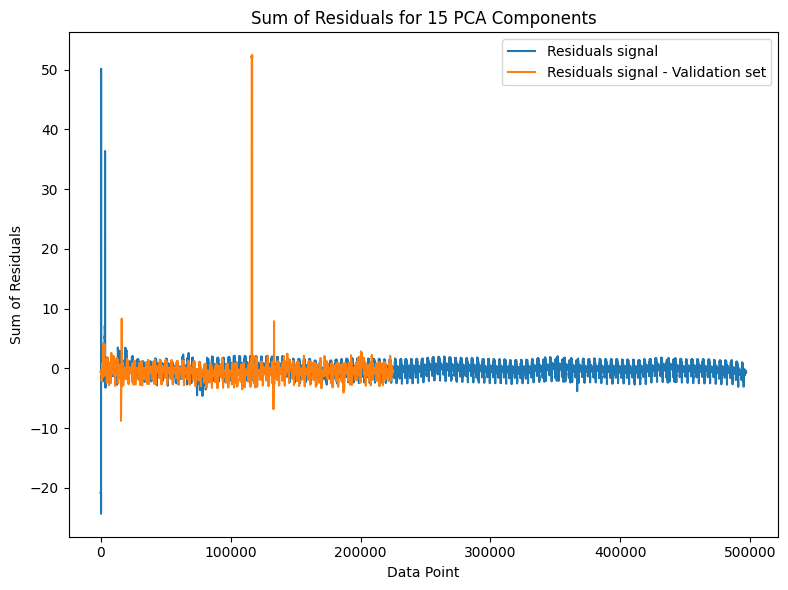

In [121]:
plt.figure(figsize=(8, 6))
plt.plot(summed_residuals.index, summed_residuals.values, linestyle='-', label=f'Residuals signal')
plt.plot(summed_residuals_val.index, summed_residuals_val.values, linestyle='-', label=f'Residuals signal - Validation set')
plt.xlabel('Data Point')
plt.ylabel('Sum of Residuals')
plt.title(f'Sum of Residuals for {components} PCA Components')
plt.legend()
plt.tight_layout()
plt.show()

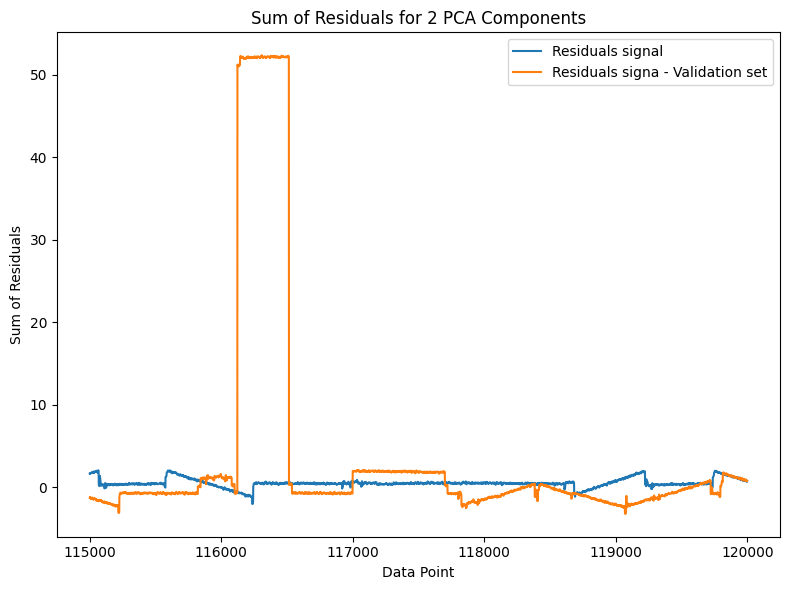

In [122]:
plt.figure(figsize=(8, 6))
plt.plot(summed_residuals[115000:120000].index, summed_residuals[115000:120000].values, linestyle='-', label=f'Residuals signal')
plt.plot(summed_residuals_val[115000:120000].index, summed_residuals_val[115000:120000].values, linestyle='-', label=f'Residuals signa - Validation set')
plt.xlabel('Data Point')
plt.ylabel('Sum of Residuals')
plt.title('Sum of Residuals for 2 PCA Components')
plt.legend()
plt.tight_layout()
plt.show()


In [151]:
# set the threshold for residuals as 95% of the variance
quantile_val = 0.99
threshold = residuals.sum(axis=1).quantile(quantile_val)
threshold_val = residuals_val.sum(axis=1).quantile(quantile_val)

# add label 1 to summed_residuals_val if it is anomalous and 0 if it is not
summed_residuals_val_label = summed_residuals_val.copy()
summed_residuals_val_label[summed_residuals_val_label > threshold_val] = 5
summed_residuals_val_label[summed_residuals_val_label <= threshold_val] = 0
print(summed_residuals_val_label.shape)

(224959,)


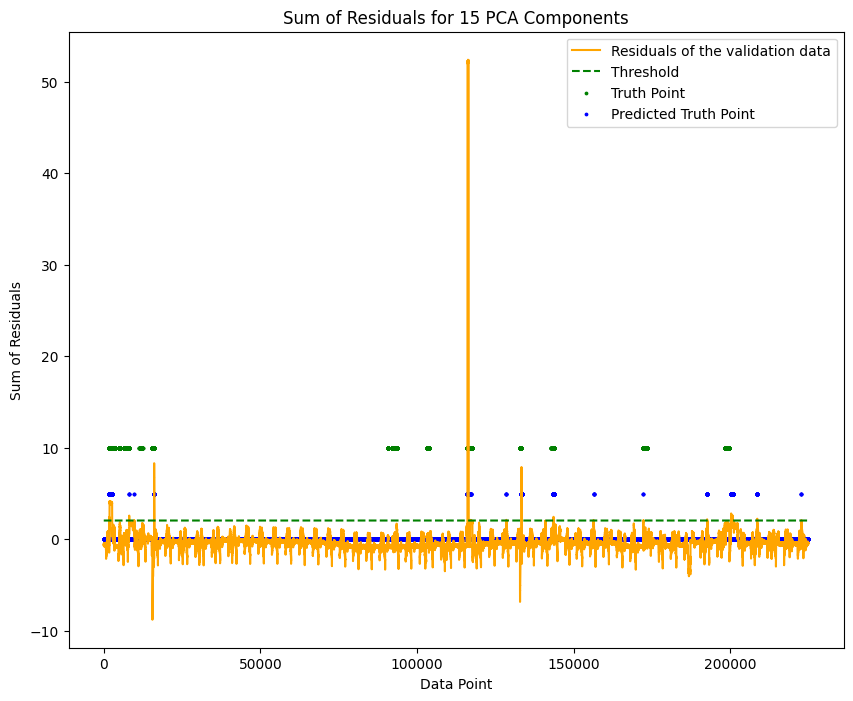

In [152]:
plt.figure(figsize=(10, 8))

# calculate the threshold line
threshold_line = np.full(len(summed_residuals_val), threshold_val)

# create masks for values above and below the threshold
above_threshold = summed_residuals_val.values > threshold_val
below_threshold = np.invert(above_threshold)

# plot the sum of residuals for all data, use different colors for data above and below threshold
# plt.plot(summed_residuals_val.index[below_threshold], summed_residuals_val.values[below_threshold], color='orange', label='Below threshold')
# plt.plot(summed_residuals_val.index[above_threshold], summed_residuals_val.values[above_threshold], color='red', label='Above threshold')
plt.plot(summed_residuals_val.index, summed_residuals_val.values, color='orange', label='Residuals of the validation data')

# plot threshold line
plt.plot(summed_residuals_val.index, threshold_line, color='g', linestyle='--', label='Threshold')

plt.scatter(residuals_val_label_1['Label'].index, residuals_val_label_1['Label'].values, s=3, color='g', label='Truth Point')
plt.scatter(summed_residuals_val_label.index, summed_residuals_val_label.values, s=3, color='b', label='Predicted Truth Point')
plt.xlabel('Data Point')
plt.ylabel('Sum of Residuals')
plt.title(f'Sum of Residuals for {components} PCA Components')
plt.legend()
plt.show()


In [136]:
# calculate f1 score of the validation set
from sklearn.metrics import f1_score
f1_score = f1_score(orginal_val['Label'], summed_residuals_val_label, average='weighted')
print(f1_score)

0.9283398936616077


### PCA Analysis

#### Do you see large abnormalities in the training data? Can you explain why these occur? 

#### Describe the kind of anomalies you can detect using PCA.

Yes for some of the signals (features) we do see large abnormalities which could be because of anomalous data. When PCA is applied, it attempts to fit the maximum variance in the data along the principal components, considering the majority of the data points. When an anomaly is present, the residual associated with this data point tends to be larger because the PCA cannot adequately represent this abnormal data point. This increased deviation represented in the residuals can help identify the anomaly as it significantly deviates from the typical residual distribution.

Typically, PCA is primarily used for detecting point anomalies, as these individual instances deviate significantly from the majority of data points. This is achieved through dimensionality reduction, where large residuals indicate potential anomalies.

## Regression Task

### PACF Analysis

In [158]:
!pip install statsmodels

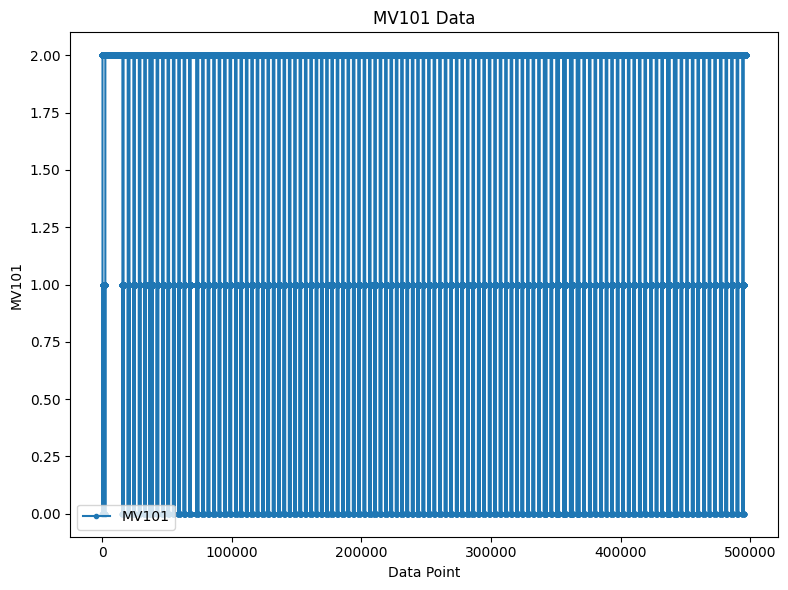

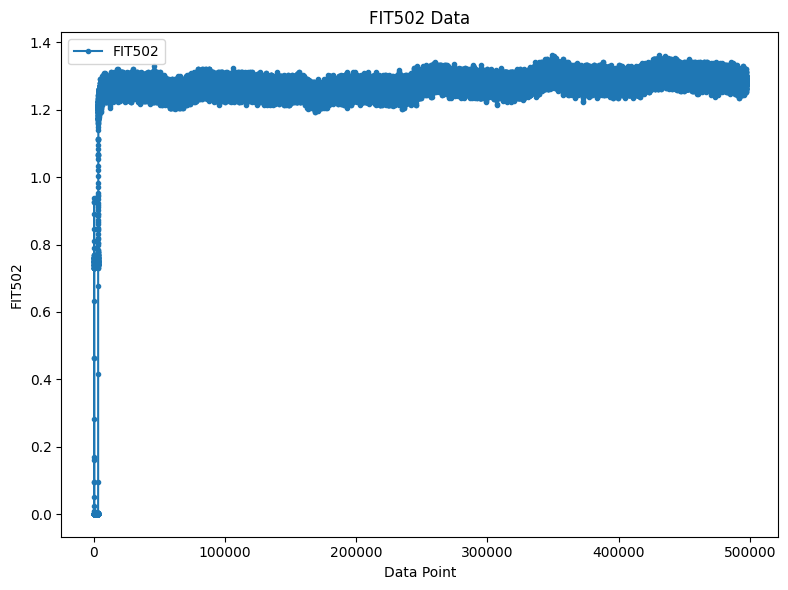

In [227]:
df_arma = pd.read_csv('train_data.csv')
df_arma_val = pd.read_csv('val_data.csv')

# plot AIT203 data over all the data points
plt.figure(figsize=(8, 6))
plt.plot(df_arma.index, df_arma['MV101'].values, marker='.', linestyle='-', label='MV101')
plt.xlabel('Data Point')
plt.ylabel('MV101')
plt.title('MV101 Data')
plt.legend()
plt.tight_layout()
plt.show()

# plot FIT502 data over all the data points
plt.figure(figsize=(8, 6))
plt.plot(df_arma.index, df_arma['FIT502'].values, marker='.', linestyle='-', label='FIT502')
plt.xlabel('Data Point')
plt.ylabel('FIT502')
plt.title('FIT502 Data')
plt.legend()
plt.tight_layout()
plt.show()

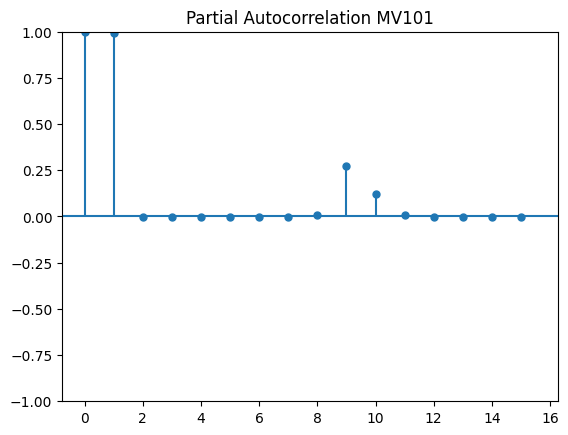

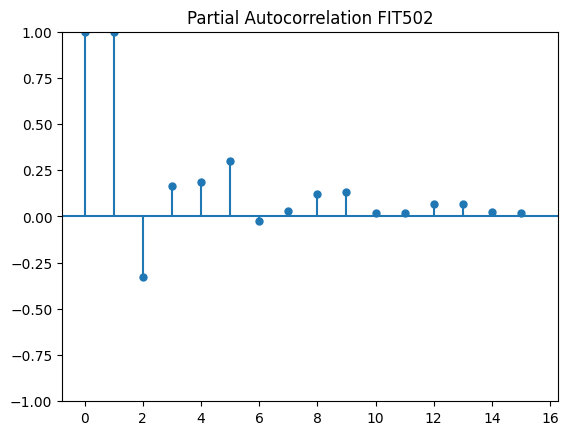

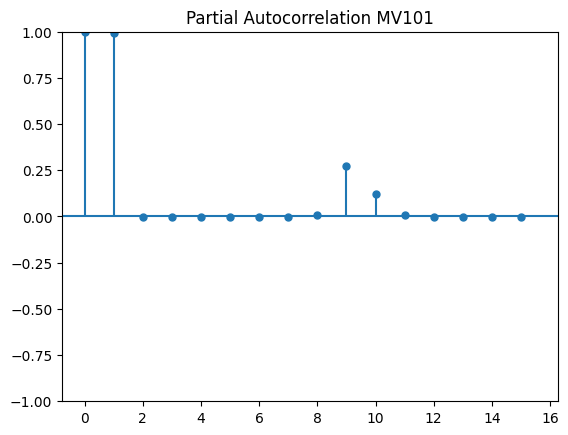

In [228]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# partial autocorrelation plot for FIT502
signal = 'FIT502'
signal2 = 'MV101'

plot_pacf(df_arma[signal], lags=15, method='ywm', title= f'Partial Autocorrelation {signal}')
plot_pacf(df_arma[signal2], lags=15, method='ywm', title= f'Partial Autocorrelation {signal2}')

Sliding window lengths from 3-5

### Autoregression Analysis

In [161]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

signal = df_arma['FIT502']

variance = np.var(signal)
print(f"Variance: {variance}")

differenced_signal = signal.diff().dropna()
variance = np.var(differenced_signal)
print(f"Variance: {variance}")

# Sliding windows of lengths 3, 4, 5

def sliding_windows2(signal, validation_signal=None):
    window_sizes = [3,4,5]

    predictions_list = []
    actual_list = []

    # loop through the window sizes
    for window_size in window_sizes:
        # Initialize lists to store the slopes and intercepts
        predictions = []

        # Loop through the signal and apply linear regression for each window
        for i in range(len(signal) - window_size):
            # Get the data points for the window
            y = signal[i : i + window_size]
            X = np.array(range(i, i + window_size)).reshape(-1, 1)

            # Fit a linear regression model to the data in the window
            model = LinearRegression().fit(X, y)

            # Use the model to make a prediction for the next data point
            next_X = np.array([[i + window_size]])
            prediction = model.predict(next_X)
            predictions.append(prediction[0])

        # Calculate the mean squared error of the predictions
        mse = mean_squared_error(signal[window_size:], predictions)

        predictions_list.append(predictions)
        actual_list.append(signal[window_size:])

        # Print the window size
        print(f"Window size: {window_size}")
        
        # Print the mean squared error
        print(f"Mean squared error: {mse}")

    return predictions_list, actual_list

Variance: 0.01089045800133936
Variance: 6.819033929579079e-05


In [162]:
# function on non-differenced signal
non_differenced_predictions, non_differenced_actual = sliding_windows2(signal)
print('\n')
# function on differenced signal
diff_predictions, diff_actual = sliding_windows2(differenced_signal)

Window size: 3
Mean squared error: 0.00010501176823902715
Window size: 4
Mean squared error: 0.0001339504619021738
Window size: 5
Mean squared error: 0.0001717174867261961


Window size: 3
Mean squared error: 0.00016049845219838236
Window size: 4
Mean squared error: 0.00014060345550328046
Window size: 5
Mean squared error: 0.0001524687075154747


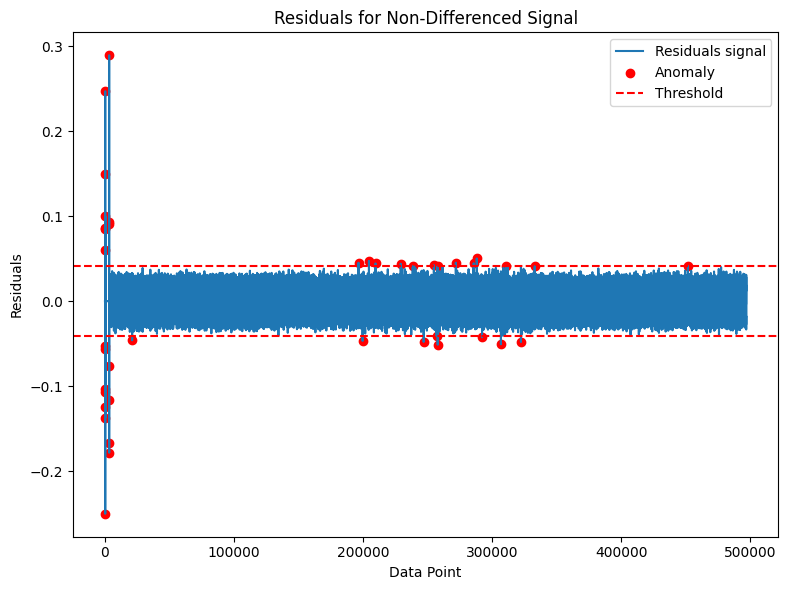

In [232]:
# calculate the residuals for the non-differenced signal for window size 3
residuals = non_differenced_actual[0] - non_differenced_predictions[0]
threshold = 4 * residuals.std()

# calculate labels for the residuals
labels = pd.Series(np.where(residuals.abs() > threshold, np.sign(residuals) * 5, 0), index=residuals.index)

# plot residuals and labels
plt.figure(figsize=(8, 6))
plt.plot(residuals, label='Residuals signal')
plt.scatter(labels[labels != 0].index, residuals[labels != 0], color='r', label='Anomaly')
plt.axhline(threshold, color='r', linestyle='--', label='Threshold')
plt.axhline(-threshold, color='r', linestyle='--')
plt.xlabel('Data Point')
plt.ylabel('Residuals')
plt.title('Residuals for Non-Differenced Signal')
plt.legend()
plt.tight_layout()
plt.show()


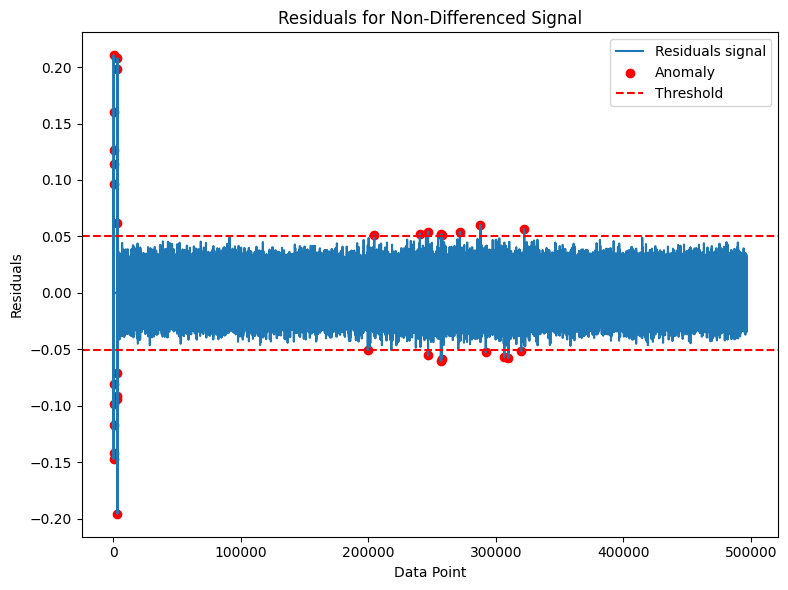

In [231]:
# calculate the residuals for the non-differenced signal for window size 3
residuals = diff_predictions[0] - diff_actual[0]
threshold = 4 * residuals.std()

# calculate labels for the residuals
labels = pd.Series(np.where(residuals.abs() > threshold, np.sign(residuals) * 5, 0), index=residuals.index)

# plot residuals and labels
plt.figure(figsize=(8, 6))
plt.plot(residuals, label='Residuals signal')
plt.scatter(labels[labels != 0].index, residuals[labels != 0], color='r', label='Anomaly')
plt.axhline(threshold, color='r', linestyle='--', label='Threshold')
plt.axhline(-threshold, color='r', linestyle='--')
plt.xlabel('Data Point')
plt.ylabel('Residuals')
plt.title('Residuals for Non-Differenced Signal')
plt.legend()
plt.tight_layout()
plt.show()


In [234]:
# Autoregression on signal3 (MV101) with window size 3
signal3 = df_arma['MV101']
# variance of signal3
variance = np.var(signal3)
print(f"Variance: {variance}")
signal3_predictions, signal3_actual = sliding_windows2(signal3)

Variance: 0.21037695158434272
Window size: 3
Mean squared error: 0.003788714952423599
Window size: 4
Mean squared error: 0.0036534110580600486
Window size: 5
Mean squared error: 0.003750842903016704


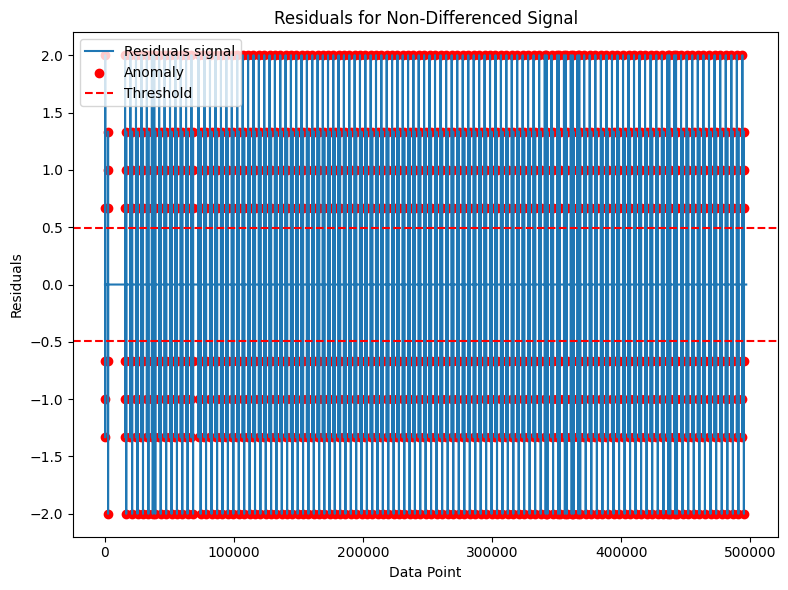

In [236]:
# calculate the residuals for the non-differenced signal for window size 3
residuals = signal3_predictions[0] - signal3_actual[0]
threshold = 8 * residuals.std()

# calculate labels for the residuals
labels = pd.Series(np.where(residuals.abs() > threshold, np.sign(residuals) * 5, 0), index=residuals.index)

# plot residuals and labels
plt.figure(figsize=(8, 6))
plt.plot(residuals, label='Residuals signal')
plt.scatter(labels[labels != 0].index, residuals[labels != 0], color='r', label='Anomaly')
plt.axhline(threshold, color='r', linestyle='--', label='Threshold')
plt.axhline(-threshold, color='r', linestyle='--')
plt.xlabel('Data Point')
plt.ylabel('Residuals')
plt.title('Residuals for Non-Differenced Signal')
plt.legend()
plt.tight_layout()
plt.show()


### Autoregression Analysis
#### Does the autocorrelation analysis agree with the obtained results? Explain why (not). Apply differencing. Does the predictive performance increase? Explain why (not).
#### What kind of anomalies can you detect using linear regression models? 
#### Which kind of sensors can be modeled effectively using linear regression?

### New old stuff

### OLD STUFF

In [7]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

df_train = pd.read_csv('train_data.csv', index_col=0)
df_val = pd.read_csv('val_data.csv', index_col=0)

signal = df_val['FIT502']

# sliding window of length 3
window_size = 3 

# initialize lists to store the slopes and intercepts
slopes = []
intercepts = []
predictions = []

# loop through the signal
for i in range(len(signal) - window_size):
    # Get the data points in the window
    X = np.array(range(window_size)).reshape(-1, 1)
    y = signal[i:i+window_size]

    # Apply linear regression
    model = LinearRegression()
    model.fit(X, y)

    # Append the slope and intercept
    intercepts.append(model.intercept_)
    slopes.append(model.coef_[0])

    # Make a prediction for the next data point
    next_point_prediction = model.predict(np.array([[window_size]]))
    predictions.append(next_point_prediction[0])

# calculate the mean squared error of the predictions
mse = mean_squared_error(signal[window_size:], predictions)

# print the mean squared error
print(f"Mean squared error: {mse}")


Mean squared error: 0.00010891786270360677


/var/folders/f5/pgcxx91x31l672vfgh983wcr0000gn/T/ipykernel_60288/3997562249.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_actual['Label'] = 0.09


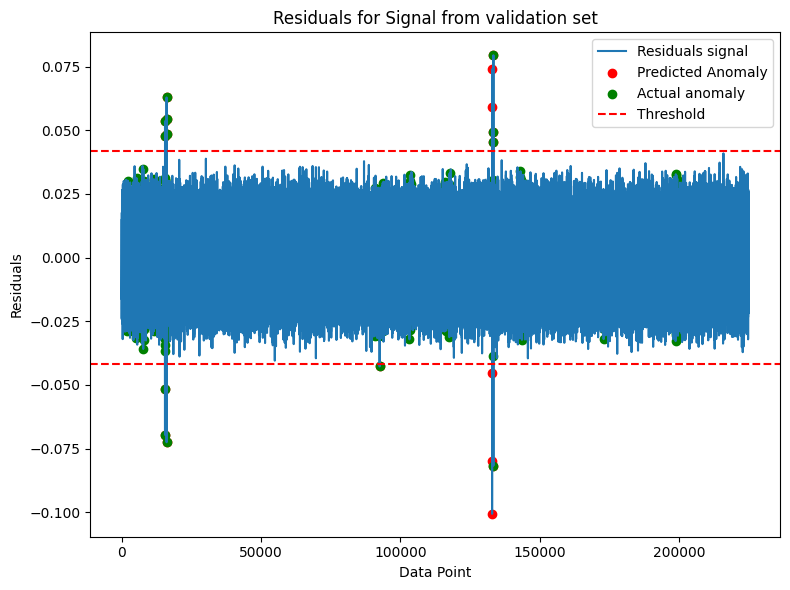

In [8]:
# get the residuals
residuals = signal[window_size:] - predictions

threshold = 4 * np.std(residuals)

# calculate labels for the residuals
labels = pd.Series(np.where(residuals.abs() > threshold, 0.08, 0), index=residuals.index)

# get labels from signal
labels_actual = df_val[df_val['Label']==1]
labels_actual['Label'] = 0.09

# get index of actual labels where label is not zero
actual_labels_index = labels_actual[labels_actual['Label'] != 0].index

# plot residuals and labels
plt.figure(figsize=(8, 6))
plt.plot(residuals, label='Residuals signal')

plt.scatter(labels[labels != 0].index, residuals[labels != 0].values, color='r',  label='Predicted Anomaly')
plt.scatter(actual_labels_index, residuals[actual_labels_index].values, color='g', label='Actual anomaly')

plt.axhline(threshold, color='r', linestyle='--', label='Threshold')
plt.axhline(-threshold, color='r', linestyle='--')
plt.xlabel('Data Point')
plt.ylabel('Residuals')
plt.title('Residuals for Signal from validation set')
plt.legend()
plt.tight_layout()
plt.show()


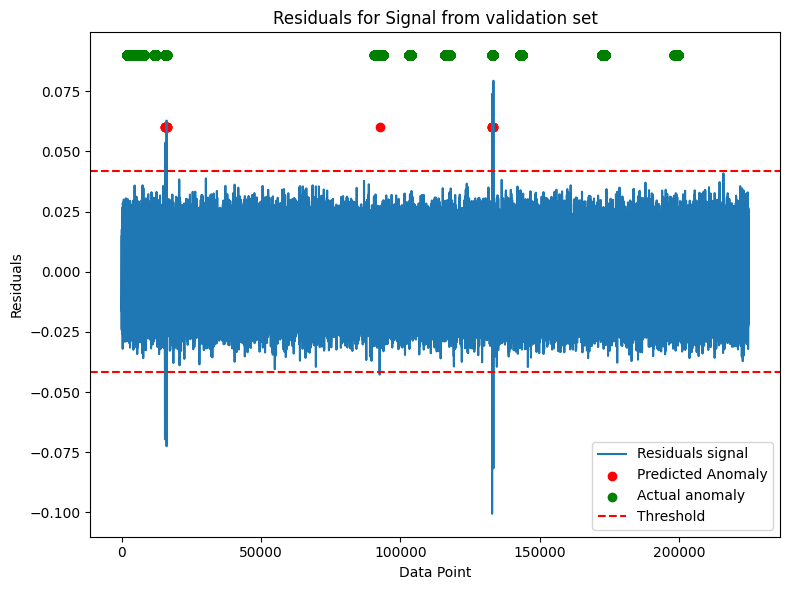

In [9]:
# get the residuals
residuals = signal[window_size:] - predictions

threshold = 4 * np.std(residuals)

# calculate labels for the residuals
labels = pd.Series(np.where(residuals.abs() > threshold, 0.08, 0), index=residuals.index)

# get labels from signal
labels_actual = df_val['Label']

# plot residuals and labels
plt.figure(figsize=(8, 6))
plt.plot(residuals, label='Residuals signal')
plt.scatter(labels[labels != 0].index,  [0.06 for i in range(len(residuals[labels != 0]))], color='r',  label='Predicted Anomaly')
plt.scatter(labels_actual[labels_actual != 0].index, [0.09]*len(labels_actual[labels_actual != 0]), color='g', label='Actual anomaly')
plt.axhline(threshold, color='r', linestyle='--', label='Threshold')
plt.axhline(-threshold, color='r', linestyle='--')
plt.xlabel('Data Point')
plt.ylabel('Residuals')
plt.title('Residuals for Signal from validation set')
plt.legend()
plt.tight_layout()
plt.show()